
Processing sampling rate: 25%

Starting Heuristic reconstruction...

Starting IHT reconstruction with k=1638, M=4096, Iterations=100
IHT Iteration 1/100, Rel Error: 1.2470
IHT Iteration 20/100, Rel Error: 0.4305
IHT Iteration 40/100, Rel Error: 0.3203
IHT Iteration 60/100, Rel Error: 0.2680
IHT Iteration 80/100, Rel Error: 0.2387
IHT Iteration 100/100, Rel Error: 0.2203

Starting ISTA reconstruction with k=1638, M=4096, Iterations=100
ISTA Iteration 1/100, Rel Error: 1.3920, Lambda: 0.1399
ISTA Iteration 20/100, Rel Error: 0.9772, Lambda: 0.1191
ISTA Iteration 40/100, Rel Error: 1.3971, Lambda: 0.1812
ISTA Iteration 60/100, Rel Error: 3.0162, Lambda: 0.4238
ISTA Iteration 80/100, Rel Error: 10.8098, Lambda: 1.5429
ISTA Iteration 100/100, Rel Error: 44.1293, Lambda: 6.3098

Processing sampling rate: 50%

Starting Heuristic reconstruction...

Starting IHT reconstruction with k=1638, M=8192, Iterations=100
IHT Iteration 1/100, Rel Error: 0.6449
IHT Iteration 20/100, Rel Error: 0.1948
IHT

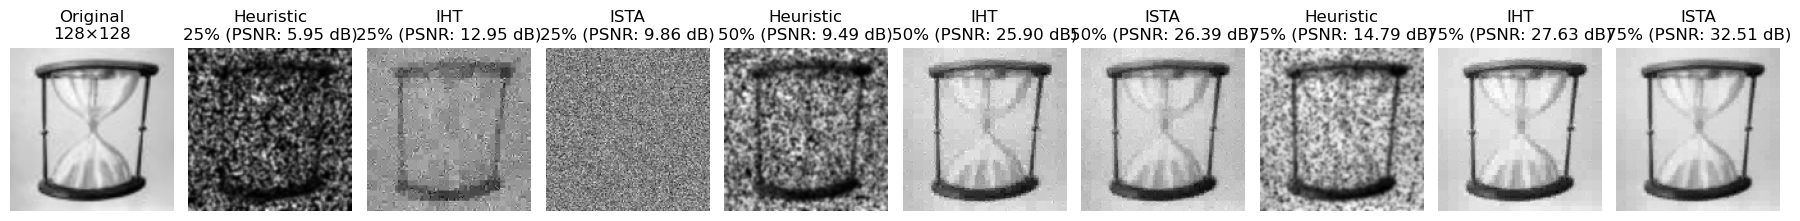

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import pywt
from scipy.ndimage import gaussian_filter
from pathlib import Path

def soft_threshold(x, lambda_val):
    return np.sign(x) * np.maximum(np.abs(x) - lambda_val, 0)

def analyze_and_apply_cs(sampling_rates=[0.25, 0.5, 0.75]):
    # === IMAGE LOADING ===
    try:
        image_path = r"C:\Users\96655\OneDrive\Desktop\New folder (4)\test\test\n03544143\n0354414300000259.jpg"
        custom_image = imread(image_path)
        if len(custom_image.shape) == 3:
            custom_image = rgb2gray(custom_image)
    except:
        from skimage import data
        custom_image = data.camera()

    # === PREPROCESSING ===
    image = resize(custom_image, (128, 128), anti_aliasing=True)
    image = image / np.max(image)
    height, width = image.shape
    N = height * width
    x_true_flat = image.flatten()

    # Wavelet properties
    wavelet = 'haar'
    level = 3
    coeffs_true = pywt.wavedec2(image, wavelet, level=level)
    arr_true, coeff_slices_true = pywt.coeffs_to_array(coeffs_true)
    s_true_flat = arr_true.flatten()

    # Sparsity level
    k_sparsity_factor = 0.10
    k = max(1, int(k_sparsity_factor * len(s_true_flat)))
    threshold_true_k = np.sort(np.abs(s_true_flat))[::-1][k-1] if k > 0 else np.sort(np.abs(s_true_flat))[::-1][-1]

    # Create sparse approximation
    s_sparse_flat = s_true_flat.copy()
    s_sparse_flat[np.abs(s_sparse_flat) < threshold_true_k] = 0
    arr_sparse = s_sparse_flat.reshape(arr_true.shape)
    coeffs_sparse = pywt.array_to_coeffs(arr_sparse, coeff_slices_true, output_format='wavedec2')
    image_sparse_approx = pywt.waverec2(coeffs_sparse, wavelet)[:height, :width]

    # Results storage
    all_results = {}
    
    for rate in sampling_rates:
        print(f"\n{'='*60}\nProcessing sampling rate: {rate*100:.0f}%\n{'='*60}")
        M = int(rate * N)
        Phi = np.random.randn(M, N) / np.sqrt(M)
        y = Phi @ x_true_flat

        # --- Heuristic Reconstruction ---
        print("\nStarting Heuristic reconstruction...")
        sample_indices = np.random.choice(N, M, replace=False)
        x_temp_flat = np.zeros(N)
        x_temp_flat[sample_indices] = x_true_flat[sample_indices]
        image_heuristic = gaussian_filter(x_temp_flat.reshape(height, width), sigma=1)
        
        # --- IHT Reconstruction ---
        print(f"\nStarting IHT reconstruction with k={k}, M={M}, Iterations=100")
        x_iht = Phi.T @ y
        for iteration in range(100):
            grad = Phi.T @ (Phi @ x_iht - y)
            x_iht = x_iht - 0.25 * grad
            coeffs = pywt.wavedec2(x_iht.reshape(height, width), wavelet, level=level)
            arr, slices = pywt.coeffs_to_array(coeffs)
            threshold = np.sort(np.abs(arr.flatten()))[::-1][k-1] if k > 0 else 0
            arr[np.abs(arr) < threshold] = 0
            coeffs = pywt.array_to_coeffs(arr, slices, output_format='wavedec2')
            x_iht = pywt.waverec2(coeffs, wavelet).flatten()
            
            if (iteration + 1) % 20 == 0 or iteration == 0:
                error = np.linalg.norm(x_true_flat - x_iht) / np.linalg.norm(x_true_flat)
                print(f"IHT Iteration {iteration + 1}/100, Rel Error: {error:.4f}")
        
        # --- ISTA Reconstruction ---
        print(f"\nStarting ISTA reconstruction with k={k}, M={M}, Iterations=100")
        x_ista = Phi.T @ y
        for iteration in range(100):
            grad = Phi.T @ (Phi @ x_ista - y)
            x_ista = x_ista - 0.25 * grad
            coeffs = pywt.wavedec2(x_ista.reshape(height, width), wavelet, level=level)
            arr, slices = pywt.coeffs_to_array(coeffs)
            
            if k > 0 and len(arr.flatten()) >= k:
                lambda_val = np.sort(np.abs(arr.flatten()))[::-1][k-1] * 0.1
            else:
                lambda_val = 0.01
                
            arr = soft_threshold(arr, lambda_val)
            coeffs = pywt.array_to_coeffs(arr, slices, output_format='wavedec2')
            x_ista = pywt.waverec2(coeffs, wavelet).flatten()
            
            if (iteration + 1) % 20 == 0 or iteration == 0:
                error = np.linalg.norm(x_true_flat - x_ista) / np.linalg.norm(x_true_flat)
                print(f"ISTA Iteration {iteration + 1}/100, Rel Error: {error:.4f}, Lambda: {lambda_val:.4f}")

        # Store results
        all_results[rate] = {
            'Heuristic': image_heuristic,
            'IHT': x_iht.reshape(height, width),
            'ISTA': x_ista.reshape(height, width)
        }

    # === METRICS CALCULATION ===
    def normalize_img(img):
        return (img - np.min(img)) / (np.max(img) - np.min(img))
    
    image_norm = normalize_img(image)
    sparse_approx_norm = normalize_img(image_sparse_approx)
    
    print("\n" + "="*60)
    print("Final Results Summary")
    print("="*60)
    print(f"Image Size: {height}x{width} (N={N})")
    print(f"Wavelet: {wavelet}, Level: {level}")
    print(f"Sparsity (k): {k} coefficients ({k_sparsity_factor*100:.1f}% of total {len(s_true_flat)})")
    
    # Calculate and print metrics for each sampling rate
    for rate in sampling_rates:
        M = int(rate * N)
        print(f"\n{'='*40}\nSampling Rate: {rate*100:.0f}% (M={M})\n{'='*40}")
        
        # Sparse approximation metrics (theoretical best)
        sparse_error = np.linalg.norm(image_norm - sparse_approx_norm) / np.linalg.norm(image_norm)
        sparse_psnr = peak_signal_noise_ratio(image_norm, sparse_approx_norm)
        sparse_ssim = structural_similarity(image_norm, sparse_approx_norm)
        
        print(f"\nSparse Approx (Best Possible):")
        print(f"  Relative Error: {sparse_error:.4f}, PSNR: {sparse_psnr:.2f} dB, SSIM: {sparse_ssim:.4f}")
        
        # Method comparisons
        for method in ['Heuristic', 'IHT', 'ISTA']:
            recon = normalize_img(all_results[rate][method])
            error = np.linalg.norm(image_norm - recon) / np.linalg.norm(image_norm)
            psnr = peak_signal_noise_ratio(image_norm, recon)
            ssim = structural_similarity(image_norm, recon)
            
            print(f"\n{method}:")
            print(f"  Relative Error: {error:.4f}, PSNR: {psnr:.2f} dB, SSIM: {ssim:.4f}")

    # === VISUALIZATION ===
    plt.figure(figsize=(18, 6))
    methods = ['Heuristic', 'IHT', 'ISTA']
    
    # Original image
    plt.subplot(1, len(sampling_rates)*len(methods)+1, 1)
    plt.imshow(image_norm, cmap='gray')
    plt.title('Original\n128×128')
    plt.axis('off')

    # Reconstructions
    for i, rate in enumerate(sampling_rates):
        for j, method in enumerate(methods):
            idx = i*len(methods) + j + 2
            plt.subplot(1, len(sampling_rates)*len(methods)+1, idx)
            recon = normalize_img(all_results[rate][method])
            psnr = peak_signal_noise_ratio(image_norm, recon)
            
            plt.imshow(recon, cmap='gray', vmin=0, vmax=1)
            plt.title(f'{method}\n{rate*100:.0f}% (PSNR: {psnr:.2f} dB)')
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Run the analysis
analyze_and_apply_cs()

Coherence Analysis Results:
Gaussian matrix coherence: 0.4568
Bernoulli matrix coherence: 0.3800
Partial Fourier matrix coherence: 0.2523

Welch bound (theoretical lower bound): 0.0709

Reconstruction Error Results:
Gaussian matrix error: 0.0714
Bernoulli matrix error: 0.0544
Partial Fourier matrix error: 0.0460
Structured matrix error: 0.3476


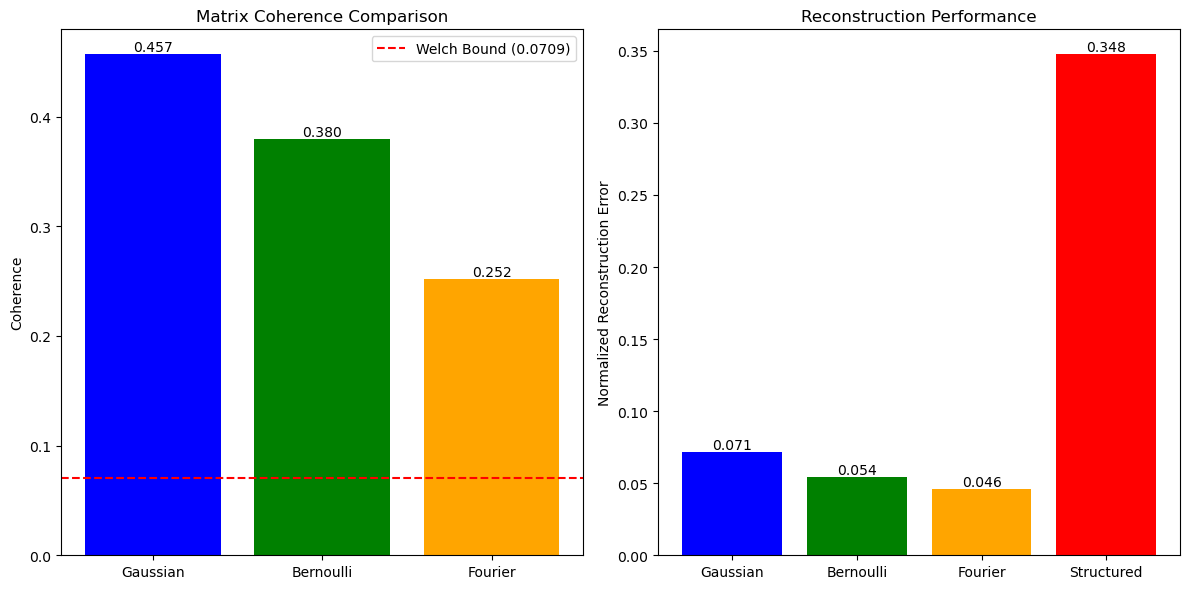

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import fftpack
from sklearn.linear_model import OrthogonalMatchingPursuit

def omp_sklearn(y, Phi, n_nonzero_coefs):
    """Orthogonal Matching Pursuit using scikit-learn"""
    omp = OrthogonalMatchingPursuit(n_nonzero_coefs=n_nonzero_coefs, fit_intercept=False)
    omp.fit(Phi, y)
    return omp.coef_

def analyze_coherence():
    # Create different sensing matrices
    N = 200  # Signal dimension
    M = 100  # Number of measurements

    # Gaussian random matrix
    Phi_gaussian = np.random.randn(M, N)
    Phi_gaussian = Phi_gaussian / np.linalg.norm(Phi_gaussian, axis=1, keepdims=True)

    # Bernoulli random matrix
    Phi_bernoulli = np.random.choice([-1, 1], size=(M, N))
    Phi_bernoulli = Phi_bernoulli / np.sqrt(M)

    # Partial Fourier matrix
    F = fftpack.dct(np.eye(N), norm='ortho')  # DCT basis
    random_rows = np.random.choice(N, M, replace=False)
    Phi_fourier = F[random_rows, :]

    # Structured sensing matrix (not good for CS)
    Phi_structured = np.zeros((M, N))
    for i in range(M):
        Phi_structured[i, i:i+N//M] = 1
    Phi_structured = Phi_structured / np.linalg.norm(Phi_structured, axis=1, keepdims=True)

    # Compute coherence for each matrix
    def compute_coherence(Phi):
        # Normalize columns
        Phi_normalized = Phi / np.linalg.norm(Phi, axis=0, keepdims=True)

        # Compute Gram matrix
        G = np.abs(Phi_normalized.T @ Phi_normalized)

        # Set diagonal to zero
        np.fill_diagonal(G, 0)

        # Maximum off-diagonal element is the coherence
        coherence = np.max(G)
        return coherence

    coherence_gaussian = compute_coherence(Phi_gaussian)
    coherence_bernoulli = compute_coherence(Phi_bernoulli)
    coherence_fourier = compute_coherence(Phi_fourier)

    print('='*40)
    print("Coherence Analysis Results:")
    print('='*40)
    print(f"Gaussian matrix coherence: {coherence_gaussian:.4f}")
    print(f"Bernoulli matrix coherence: {coherence_bernoulli:.4f}")
    print(f"Partial Fourier matrix coherence: {coherence_fourier:.4f}")

    # Lower bound on coherence
    welch_bound = np.sqrt((N - M) / (M * (N - 1)))
    print(f"\nWelch bound (theoretical lower bound): {welch_bound:.4f}")

    # Test recovery performance
    k = 10  # Sparsity level
    s_true = np.zeros(N)
    indices = np.random.choice(N, k, replace=False)
    s_true[indices] = np.random.randn(k)

    noise_level = 0.01

    def test_recovery(Phi, name):
        y = Phi @ s_true
        y_noisy = y + noise_level * np.linalg.norm(y) * np.random.randn(M)
        s_rec = omp_sklearn(y_noisy, Phi, k)
        error = np.linalg.norm(s_true - s_rec) / np.linalg.norm(s_true)
        return error

    error_gaussian = test_recovery(Phi_gaussian, "Gaussian")
    error_bernoulli = test_recovery(Phi_bernoulli, "Bernoulli")
    error_fourier = test_recovery(Phi_fourier, "Fourier")
    error_structured = test_recovery(Phi_structured, "Structured")

    print('\n' + '='*40)
    print("Reconstruction Error Results:")
    print('='*40)
    print(f"Gaussian matrix error: {error_gaussian:.4f}")
    print(f"Bernoulli matrix error: {error_bernoulli:.4f}")
    print(f"Partial Fourier matrix error: {error_fourier:.4f}")
    print(f"Structured matrix error: {error_structured:.4f}")

    # Visualization
    plt.figure(figsize=(12, 6))
    
    # Coherence plot
    plt.subplot(1, 2, 1)
    matrices = ["Gaussian", "Bernoulli", "Fourier"]
    coherences = [coherence_gaussian, coherence_bernoulli, coherence_fourier]
    
    bars = plt.bar(matrices, coherences, color=['blue', 'green', 'orange'])
    plt.axhline(y=welch_bound, color='r', linestyle='--', label=f'Welch Bound ({welch_bound:.4f})')
    
    # Add coherence values on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom')
    
    plt.ylabel('Coherence')
    plt.title('Matrix Coherence Comparison')
    plt.legend()

    # Error plot
    plt.subplot(1, 2, 2)
    errors = [error_gaussian, error_bernoulli, error_fourier, error_structured]
    matrices_with_struct = matrices + ["Structured"]
    
    bars = plt.bar(matrices_with_struct, errors, color=['blue', 'green', 'orange', 'red'])
    
    # Add error values on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom')
    
    plt.ylabel('Normalized Reconstruction Error')
    plt.title('Reconstruction Performance')
    
    plt.tight_layout()
    plt.show()

# Run the coherence analysis
analyze_coherence()